## <font color='darkblue'>Preface</font>
([article source](https://realpython.com/intro-to-python-threading/)) <b><font size='3ptx'>Python threading allows you to have different parts of your program run concurrently and can simplify your design. If you’ve got some experience in Python and want to speed up your program using threads, then this tutorial is for you!</font></b>

In this article, you’ll learn:
* What threads are
* How to create threads and wait for them to finish
* How to use a [**ThreadPoolExecutor**](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.ThreadPoolExecutor)
* How to avoid race conditions
* How to use the common tools that Python threading provides


If you’re not sure if you want to use Python [**threading**](https://docs.python.org/3/library/threading.html), [**asyncio**](https://docs.python.org/3/library/asyncio.html), or [**multiprocessing**](https://docs.python.org/3/library/multiprocessing.html), then you can check out [Speed Up Your Python Program With Concurrency](https://realpython.com/python-concurrency/).

All of the sources used in this tutorial are available to you in the [Real Python GitHub repo](https://github.com/realpython/materials/tree/master/intro-to-threading).

In [3]:
import copy
from datetime import datetime
import logging
import matplotlib.pyplot as plt
import threading
import time

format = "%(asctime)s: %(message)s"
logging.basicConfig(
    format=format, level=logging.DEBUG, datefmt="%H:%M:%S")

<a id='sect0'></a>
### <font color='darkgreen'>Agenda</font>
* <font size='3ptx'><b><a href='#sect1'>What Is a Thread?</a></b></font>
* <font size='3ptx'><b><a href='#sect2'>Starting a Thread</a></b></font>
  * <b><a href='#sect2_1'>Daemon Threads</a></b>
  * <b><a href='#sect2_2'>`join()` a Thread</a></b>
* <font size='3ptx'><b><a href='#sect3'>Working With Many Threads</a></b></font>
* <font size='3ptx'><b><a href='#sect4'>Using a `ThreadPoolExecutor`</a></b></font>
* <font size='3ptx'><b><a href='#sect5'>Race Conditions</a></b></font>
* <font size='3ptx'><b><a href='#sect6'>Basic Synchronization Using `Lock`</a></b></font>
* <font size='3ptx'><b><a href='#sect7'>Deadlock</a></b></font>
* <font size='3ptx'><b><a href='#sect8'>Producer-Consumer Threading</a></b></font>
  * <b><a href='#sect8_1'>Producer-Consumer Using Lock</a></b>
  * <b><a href='#sect8_2'>Producer-Consumer Using Queue</a></b>
* <font size='3ptx'><b><a href='#sect9'>Threading Objects</a></b></font>
  * <b><a href='#sect9_1'>Semaphore</a></b>
  * <b><a href='#sect9_2'>Timer</a></b>
  * <b><a href='#sect9_3'>Barrier</a></b>

<a id='sect1'></a>
## <font color='darkblue'>What Is a Thread?</font>
<b><font size='3ptx'>A thread is a separate flow of execution. This means that your program will have two things happening at once. But for most Python 3 implementations the different threads do not actually execute at the same time: they merely appear to.</font></b>

It’s tempting to think of threading as having two (<font color='brown'>or more</font>) different processors running on your program, each one doing an independent task at the same time. That’s almost right. <b><font color='darkred'>The threads may be running on different processors, but they will only be running one at a time</font></b>.

Getting multiple tasks running simultaneously requires a non-standard implementation of Python, writing some of your code in a different language, or using [**multiprocessing**](https://docs.python.org/3/library/multiprocessing.html) which comes with some extra overhead.

Because of the way CPython implementation of Python works, threading may not speed up all tasks. This is due to interactions with the [**GIL**](https://realpython.com/python-gil/) that essentially limit one Python thread to run at a time.

<b>Tasks that spend much of their time waiting for external events are generally good candidates for threading</b>. Problems that require heavy CPU computation and spend little time waiting for external events might not run faster at all.

<b>This is true for code written in Python and running on the standard CPython implementation</b>. If your threads are written in C they have the ability to release the GIL and run concurrently. If you are running on a different Python implementation, check with the documentation too see how it handles threads.

<b>If you are running a standard Python implementation, writing in only Python, and have a CPU-bound problem, you should check out the [multiprocessing](https://docs.python.org/3/library/multiprocessing.html) module instead</b>.

<b>Architecting your program to use threading can also provide gains in design clarity. Most of the examples you’ll learn about in this tutorial are not necessarily going to run faster because they use threads</b>. Using threading in them helps to make the design cleaner and easier to reason about.

So, let’s stop talking about threading and start using it!

<a id='sect2'></a>
## <font color='darkblue'>Starting a Thread</font> ([back](#sect0))
([article source](https://realpython.com/intro-to-python-threading/#starting-a-thread)) Now that you’ve got an idea of what a thread is, let’s learn how to make one. The Python standard library provides [**threading**](https://docs.python.org/3/library/threading.html), which contains most of the primitives you’ll see in this article. <font color='blue'><b>Thread</b></font>, in this module, nicely encapsulates threads, providing a clean interface to work with them.

To start a separate thread, you create a <font color='blue'><b>Thread</b></font> instance and then tell it to <font color='blue'>.start()</font>:

In [2]:
def thread_function(name):
    logging.info("Thread %s: starting", name)
    time.sleep(2)
    logging.info("Thread %s: finishing", name)
    
    
logging.info("Main    : before creating thread")

x = threading.Thread(target=thread_function, args=(1,))
logging.info("Main    : before running thread")

# Starting the thread
x.start()

logging.info("Main    : wait for the thread to finish")
# x.join()
logging.info("Main    : all done")

02:05:12: Main    : before creating thread
02:05:12: Main    : before running thread
02:05:12: Thread 1: starting
02:05:12: Main    : wait for the thread to finish
02:05:12: Main    : all done
02:05:14: Thread 1: finishing


If you look around the logging statements, you can see that the main section is creating and starting the thread:
```python
x = threading.Thread(target=thread_function, args=(1,))
x.start()
```

When you create a Thread, you pass it a function and a list containing the arguments to that function. In this case, you’re telling the <b><font color='blue'>Thread</font></b> to run <font color='blue'>thread_function()</font> and to pass it `1` as an argument.

For this article, you’ll use sequential integers as names for your threads. There is [**threading**.get_ident()](https://docs.python.org/3/library/threading.html#threading.get_ident), which returns a unique name for each thread, but these are usually neither short nor easily readable.

You’ll notice that the <b><font color='blue'>Thread</font></b> finished after the Main section of your code did. You’ll come back to why that is and talk about the mysterious line twenty in the next section.

<a id='sect2_1'></a>
### <font color='darkgreen'><b>Daemon Threads</b></font>
<font size='3ptx'><b>In computer science, a [daemon](https://en.wikipedia.org/wiki/Daemon_(computing)) is a process that runs in the background.</b></font>

Python threading has a more specific meaning for `daemon`. A daemon thread will shut down immediately when the program exits. One way to think about these definitions is to <b>consider the daemon thread a thread that runs in the background without worrying about shutting it down</b>.

<b>If a program is running Threads that are not daemons, then the program will wait for those threads to complete before it terminates</b>. Threads that are daemons, however, are just killed wherever they are when the program is exiting.

From log below, you’ll notice that there is a pause (of about 2 seconds) after all done message and before the thread is finished.
```
03:23:10: Main    : wait for the thread to finish
03:23:12: Thread 1: finishing
03:23:12: Main    : all done
```

<b>This pause is Python waiting for the non-daemonic thread to complete</b>. When your Python program ends, part of the shutdown process is to clean up the threading routine. If you look at the [source for Python threading](https://github.com/python/cpython/blob/df5cdc11123a35065bbf1636251447d0bfe789a5/Lib/threading.py#L1263), you’ll see that <font color='blue'>threading._shutdown()</font> walks through all of the running threads and calls <font color='blue'>.join()</font> on every one that does not have the `daemon` flag set.

<b>So your program waits to exit because the thread itself is waiting in a sleep</b>. As soon as it has completed and printed the message, <font color='blue'>.join()</font> will return and the program can exit.

Frequently, this behavior is what you want, but there are other options available to us. Let’s first repeat the program with a daemon thread. You do that by changing how you construct the Thread, adding the `daemon=True` flag:
```python
  logging.info("Main    : before creating thread")

  x = threading.Thread(target=thread_function, args=(1,), daemon=True)
  logging.info("Main    : before running thread")

  # Starting the thread
  x.start()

  logging.info("Main    : wait for the thread to finish")
  logging.info("Main    : all done")
```

%run start_daemon_thread.py

The difference here is that the final line of the output is missing. <font color='blue'>thread_function()</font> did not get a chance to complete. <b>It was a daemon thread, so when main program reached the end of its code and the program wanted to finish, the daemon was killed</b>.

<a id='sect2_2'></a>
### <font color='darkgreen'>`join()` a Thread</font>
<b>Daemon threads are handy, but what about when you want to wait for a thread to stop?</b> What about when you want to do that and not exit your program? Now let’s go back to your original program and look at that commented out line twenty:
```python
# x.join()
```

To tell one thread to wait for another thread to finish, you call [.join()](https://docs.python.org/3/library/threading.html#threading.Thread.join). If you uncomment that line, the main thread will pause and wait for the thread `x` to complete running.

Did you test this on the code with the daemon thread or the regular thread? It turns out that it doesn’t matter. <b>If you [.join()](https://docs.python.org/3/library/threading.html#threading.Thread.join) a thread, that statement will wait until either kind of thread is finished.</b>

<a id='sect3'></a>
## <font color='darkblue'>Working With Many Threads</font> ([back](#sect0))
<b><font size='3ptx'>The example code so far has only been working with two threads: the main thread and one you started with the [threading.Thread](https://docs.python.org/3/library/threading.html#thread-objects) object.</font></b>

Frequently, you’ll want to start a number of threads and have them do interesting work. Let’s start by looking at the harder way of doing that, and then you’ll move on to an easier method.

The harder way of starting multiple threads is the one you already know:
* `start_multi_threads_p1.py`:

```python
import logging
import threading
import time

def thread_function(name):
    logging.info("Thread %s: starting", name)
    time.sleep(2)
    logging.info("Thread %s: finishing", name)

if __name__ == "__main__":
    format = "%(asctime)s: %(message)s"
    logging.basicConfig(format=format, level=logging.INFO,
                        datefmt="%H:%M:%S")

    threads = list()
    for index in range(3):
        logging.info("Main    : create and start thread %d.", index)
        x = threading.Thread(target=thread_function, args=(index,))
        threads.append(x)
        x.start()

    for index, thread in enumerate(threads):
        logging.info("Main    : before joining thread %d.", index)
        thread.join()
        logging.info("Main    : thread %d done", index)
```

This code uses the same mechanism you saw above to start a thread, create a <b><font color='blue'>Thread</font></b> object, and then call [.start()](https://docs.python.org/3/library/threading.html#threading.Thread.start). The program keeps a list of <b><font color='blue'>Thread</font></b> objects so that it can then wait for them later using [.join()](https://docs.python.org/3/library/threading.html#threading.Thread.join).

Running this code multiple times will likely produce some interesting results. Here’s an example output from my machine:

In [3]:
%run start_multi_threads_p1.py

02:29:54: Main    : create and start thread 0.
02:29:54: Thread 0: starting
02:29:54: Main    : create and start thread 1.
02:29:54: Thread 1: starting
02:29:54: Main    : create and start thread 2.
02:29:54: Thread 2: starting
02:29:54: Main    : before joining thread 0.
02:29:56: Thread 0: finishing
02:29:56: Main    : thread 0 done
02:29:56: Main    : before joining thread 1.
02:29:56: Thread 1: finishing
02:29:56: Main    : thread 1 done
02:29:56: Main    : before joining thread 2.
02:29:56: Thread 2: finishing
02:29:56: Main    : thread 2 done


If you walk through the output carefully, you’ll see all three threads getting started in the order you might expect, but in this case they finish in the opposite order! Multiple runs will produce different orderings. Look for the` Thread x: finishing` message to tell you when each thread is done.

<font size='3ptx'><b>The order in which threads are run is determined by the operating system and can be quite hard to predict</b></font>. It may (<font color='brown'>and likely will</font>) vary from run to run, so you need to be aware of that when you design algorithms that use **[threading](https://docs.python.org/3/library/threading.html#)**.

Fortunately, Python gives you several primitives that you’ll look at later to help coordinate threads and get them running together. Before that, let’s look at how to make managing a group of threads a bit easier.

<a id='sect4'></a>
## <font color='darkblue'>Using a `ThreadPoolExecutor`</font> ([back](#sect0))
<b><font size='3ptx'>There’s an easier way to start up a group of threads than the one you saw above. It’s called a [**ThreadPoolExecutor**](https://docs.python.org/3/library/concurrent.futures.html#threadpoolexecutor), and it’s part of the standard library in [**concurrent.futures**](https://docs.python.org/3/library/concurrent.futures.html#) (<font color='brown'>as of Python 3.2</font>).</font></b>

The easiest way to create it is as a context manager, using the [with statement](https://realpython.com/python-with-statement/) to manage the creation and destruction of the pool.

Here’s the \_\_main__ from the last example rewritten to use a [**ThreadPoolExecutor**](https://docs.python.org/3/library/concurrent.futures.html#threadpoolexecutor):

* `start_multi_threads_by_thread_pool_executor.py`

```python
import concurrent.futures

# [rest of code]

if __name__ == "__main__":
    format = "%(asctime)s: %(message)s"
    logging.basicConfig(format=format, level=logging.INFO,
                        datefmt="%H:%M:%S")

    with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
        executor.map(thread_function, range(3))
```

The code creates a [**ThreadPoolExecutor**](https://docs.python.org/3/library/concurrent.futures.html#threadpoolexecutor) as a context manager, telling it how many worker threads it wants in the pool. It then uses [.map()](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Executor.map) to step through an iterable of things, in your case <font color='blue'>range(3)</font>, passing each one to a thread in the pool.

The end of the with block causes the [**ThreadPoolExecutor**](https://docs.python.org/3/library/concurrent.futures.html#threadpoolexecutor) to do a <font color='blue'>.join()</font> on each of the threads in the pool. <b>It is strongly recommended that you use [ThreadPoolExecutor](https://docs.python.org/3/library/concurrent.futures.html#threadpoolexecutor) as a context manager when you can so that you never forget to <font color='blue'>.join()</font> the threads.</b>

Running your corrected example code will produce output that looks like this:

In [1]:
%run start_multi_threads_by_thread_pool_executor.py

05:37:33: Thread 0: !!! starting !!!
05:37:33: Thread 0: Handling task 0...
05:37:33: Thread 1: !!! starting !!!
05:37:33: Thread 0: Handling task 1...
05:37:33: Thread 2: !!! starting !!!
05:37:33: Thread 1: Handling task 0...
05:37:33: Thread 0: Handling task 2...
05:37:33: Thread 2: Handling task 0...
05:37:33: Thread 1: Handling task 1...
05:37:33: Thread 0: Handling task 3...
05:37:33: Thread 2: Handling task 1...
05:37:33: Thread 1: Handling task 2...
05:37:33: Thread 0: Handling task 4...
05:37:33: Thread 2: Handling task 2...
05:37:33: Thread 1: Handling task 3...
05:37:33: === Thread 0: finishing ===
05:37:33: Thread 2: Handling task 3...
05:37:33: Thread 1: Handling task 4...
05:37:33: Thread 2: Handling task 4...
05:37:33: === Thread 1: finishing ===
05:37:33: === Thread 2: finishing ===


### <b><font color='darkgreen'>IO Bound tasks is a perfect fit for multi-threads</font></b>
Consider you want to craw below URLs by using [**requests**](https://pypi.org/project/requests/) ([Top 500 URLs](https://moz.com/top500)):

In [21]:
import requests

URLs = [
    'https://pypi.org/project/requests/',
    'https://stackoverflow.com/',
    'https://www.google.com/',
    'https://www.facebook.com/',
    'https://realpython.com/',
    'https://blog.gtwang.org/',
    'https://www.geeksforgeeks.org/',
    'https://www.youtube.com/',
    'https://www.apple.com/',
    'https://www.microsoft.com/',
    'https://www.linkedin.com/feed/',
    'https://en.wikipedia.org/wiki/Main_Page',
    'https://www.mozilla.org/',
    'https://telegram.org/',
    'https://github.com/',
    'https://medium.com/',
    'https://edition.cnn.com/',
]

If we do it sequentially in main thread:

In [22]:
%%time
for url in URLs:
    r = requests.get(url)
    if r.status_code != 200:
        print(f'Failed to handle URL={url} with status code as {r.status_code}')

    print(f'URL={url} is crawled successfully!')

URL=https://pypi.org/project/requests/ is crawled successfully!
URL=https://stackoverflow.com/ is crawled successfully!
URL=https://www.google.com/ is crawled successfully!
URL=https://www.facebook.com/ is crawled successfully!
URL=https://realpython.com/ is crawled successfully!
URL=https://blog.gtwang.org/ is crawled successfully!
URL=https://www.geeksforgeeks.org/ is crawled successfully!
URL=https://www.youtube.com/ is crawled successfully!
URL=https://www.apple.com/ is crawled successfully!
URL=https://www.microsoft.com/ is crawled successfully!
URL=https://www.linkedin.com/feed/ is crawled successfully!
URL=https://en.wikipedia.org/wiki/Main_Page is crawled successfully!
URL=https://www.mozilla.org/ is crawled successfully!
URL=https://telegram.org/ is crawled successfully!
URL=https://github.com/ is crawled successfully!
Failed to handle URL=https://medium.com/ with status code as 429
URL=https://medium.com/ is crawled successfully!
URL=https://edition.cnn.com/ is crawled succes

Let's observe how processing time decreases as the number of threads increases:

In [23]:
def crawl_url(name, url_queue):
    while url_queue:
        url = url_queue.pop(0)
        r = requests.get(url)
        if r.status_code != 200:
            print(f'Failed to handle URL={url} with status code as {r.status_code}')

        print(f'Thread-{name}: URL={url} is crawled successfully!')

In [24]:
thread_num_2_process_time = {}
for thread_num in range(2, 11):
    urls = copy.copy(URLs)
    start_time = datetime.now()
    with concurrent.futures.ThreadPoolExecutor(max_workers=thread_num) as executor:
        executor.map(lambda p: crawl_url(*p), ((i, urls) for i in range(thread_num)))
        
    time_diff = datetime.now() - start_time
    thread_num_2_process_time[thread_num] = time_diff.total_seconds()
    print(f'Thread number={thread_num} spent {time_diff.total_seconds():.02f}s')

Thread-0: URL=https://pypi.org/project/requests/ is crawled successfully!
Thread-0: URL=https://www.google.com/ is crawled successfully!
Thread-1: URL=https://stackoverflow.com/ is crawled successfully!
Thread-0: URL=https://www.facebook.com/ is crawled successfully!
Thread-0: URL=https://blog.gtwang.org/ is crawled successfully!
Thread-0: URL=https://www.geeksforgeeks.org/ is crawled successfully!
Thread-1: URL=https://realpython.com/ is crawled successfully!
Thread-0: URL=https://www.youtube.com/ is crawled successfully!
Thread-1: URL=https://www.apple.com/ is crawled successfully!
Thread-0: URL=https://www.microsoft.com/ is crawled successfully!
Thread-0: URL=https://en.wikipedia.org/wiki/Main_Page is crawled successfully!
Thread-0: URL=https://www.mozilla.org/ is crawled successfully!
Thread-1: URL=https://www.linkedin.com/feed/ is crawled successfully!
Thread-0: URL=https://telegram.org/ is crawled successfully!
Thread-1: URL=https://github.com/ is crawled successfully!
Thread-1: 

In [32]:
def show_line_chart(thread_num_2_process_time):
    plt.rcParams['figure.figsize'] = [7, 3]
    x_axis = []
    y_axis = []
    for thread_num, spent_time in thread_num_2_process_time.items():
        x_axis.append(f'thd-{thread_num}')
        y_axis.append(spent_time)

    plt.plot(x_axis, y_axis)
    plt.title('Task Completion Time vs. Number of Threads')
    plt.xlabel('# of thread(s)')
    plt.ylabel('Spent time (s)')
    plt.show()

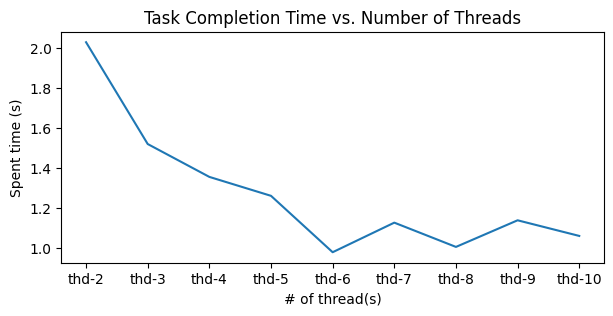

In [33]:
show_line_chart(thread_num_2_process_time)

Can you guess what `thd-10` take more time than `thd-6`?

<a id='sect5'></a>
## <font color='darkblue'>Race Conditions</font> ([back](#sect0))
<b><font size='3ptx'>Before you move on to some of the other features tucked away in Python threading, let’s talk a bit about one of the more difficult issues you’ll run into when writing threaded programs: [race conditions](https://en.wikipedia.org/wiki/Race_condition).</font></b>

Once you’ve seen what a race condition is and looked at one happening, you’ll move on to some of the primitives provided by the standard library to prevent race conditions from happening.

Race conditions can occur when two or more threads access a shared piece of data or resource. In this example, you’re going to create a large race condition that happens every time, but be aware that <b>most race conditions are not this obvious. Frequently, they only occur rarely, and they can produce confusing results. As you can imagine, this makes them quite difficult to debug</b>.

Fortunately, this race condition will happen every time, and you’ll walk through it in detail to explain what is happening.

For this example, you’re going to write a class that updates a database. Okay, you’re not really going to have a database: you’re just going to fake it, because that’s not the point of this article.

Your <b><font color='blue'>FakeDatabase</font></b> will have <font color='blue'>.\_\_init__()</font> and <font color='blue'>.update()</font> methods:

```python
class FakeDatabase:
    def __init__(self):
        self.value = 0

    def update(self, name):
        logging.info("Thread %s: starting update", name)
        local_copy = self.value
        local_copy += 1
        time.sleep(0.1)
        self.value = local_copy
        logging.info("Thread %s: finishing update", name)
```

FakeDatabase is keeping track of a single number: `.value`. This is going to be the shared data on which you’ll see the race condition.

In this case, reading from the database just means copying `.value` to a local variable. The computation is just to add one to the value and then <font color='blue'>.sleep()</font> for a little bit. Finally, it writes the value back by copying the local value back to `.value`.

Here’s how you’ll use this <b><font color='blue'>FakeDatabase</font></b>:

```python
if __name__ == "__main__":
    database = FakeDatabase()
    logging.info("Testing update. Starting value is %d.", database.value)
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        for index in range(2):
            executor.submit(database.update, index)
    logging.info("Testing update. Ending value is %d.", database.value)
```

The program creates a [**ThreadPoolExecutor**](https://docs.python.org/3/library/concurrent.futures.html#threadpoolexecutor) with two threads and then calls <font color='blue'>.submit()</font> on each of them, telling them to run <font color='blue'>database.update()</font>.

[.submit()](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Executor.submit) has a signature that allows both positional and named arguments to be passed to the function running in the thread. In the usage above, index is passed as the first and only positional argument to <font color='blue'>database.update()</font>. You’ll see later in this article where you can pass multiple arguments in a similar manner.

Since each thread runs <font color='blue'>.update()</font>, and <font color='blue'>.update()</font> adds one to .value, you might expect `database.value` to be 2 when it’s printed out at the end. But you wouldn’t be looking at this example if that was the case. If you run the above code, the output looks like this:

In [10]:
%run update_fakedb_ex1.py

06:49:44: Testing update. Starting value is 0.
06:49:44: Thread 0: starting update
06:49:44: Thread 1: starting update
06:49:44: Testing update. Ending value is 0.


<a id='sect5_1'></a>
### <font color='darkgreen'>One Thread</font>
<b><font size='3ptx'>Before you dive into this issue with two threads, let’s step back and talk a bit about some details of how threads work.</font></b>

You won’t be diving into all of the details here, as that’s not important at this level. <b>We’ll also be simplifying a few things in a way that won’t be technically accurate but will give you the right idea of what is happening</b>.

When you tell your [**ThreadPoolExecutor**](https://docs.python.org/3/library/concurrent.futures.html#threadpoolexecutor) to run each thread, you tell it which function to run and what parameters to pass to it: `executor.submit(database.update, index)`.

Each thread is going to have a reference to the same <b><font color='blue'>FakeDatabase</font></b> object, `database`. Each thread will also have a unique value, index, to make the logging statements a bit easier to read:

![one thread](images/1.PNG)

When the thread starts running <font color='blue'>.update()</font>, it has its own version of all of the data local to the function. In the case of <font color='blue'>.update()</font>, this is `local_copy`. This is definitely a good thing. Otherwise, two threads running the same function would always confuse each other. <b>It means that all variables that are scoped</b> (<font color='brown'>or local</font>) <b>to a function are thread-safe</b>.

Now you can start walking through what happens if you run the program above with a single thread and a single call to <font color='blue'>.update()</font>.

The image below steps through the execution of <font color='blue'>.update()</font> if only a single thread is run. The statement is shown on the left followed by a diagram showing the values in the thread’s local_copy and the shared `database.value`:

![one thread flow](images/2.png)

So far, so good. You ran <font color='blue'>.update()</font> once and FakeDatabase.value was incremented to one.

<a id='sect5_2'></a>
### <font color='darkgreen'>Two Threads</font>
<b><font size='3ptx'>Getting back to the race condition, the two threads will be running concurrently but not at the same time. They will each have their own version of `local_copy` and will each point to the same database. It is this shared database object that is going to cause the problems.</font></b>

The two threads have interleaving access to a single shared object, overwriting each other’s results. Similar race conditions can arise when one thread frees memory or closes a file handle before the other thread is finished accessing it. Let's take a close look to see how it occurs.

The program starts with Thread 1 running `.update()`:

![thread two](images/3.PNG)

When Thread 1 calls `time.sleep()`, it allows the other thread to start running. This is where things get interesting.

Thread 2 starts up and does the same operations. It’s also copying `database.value` into its private `local_copy`, and this shared `database.value` has not yet been updated:

![two thread](images/4.PNG)

When Thread 2 finally goes to sleep, the shared database.value is still unmodified at zero, and both private versions of local_copy have the value one.

Thread 1 now wakes up and saves its version o`f local_co`py and then terminates, giving Thread 2 a final chance to run. Thread 2 has no idea that Thread 1 ran and update`d database.val`ue while it was sleeping. It stores its version o`f local_co`py int`o database.val`ue, also setting it to on

![two thread](images/5.PNG)e:

### <b><font color='darkgreen'>Why This Isn’t a Silly Example</font></b>
The example above is contrived to make sure that the race condition happens every time you run your program. Because the operating system can swap out a thread at any time, it is possible to interrupt a statement like x = x + 1 after it has read the value of x but before it has written back the incremented value.

<a id='sect6'></a>
## <font color='darkblue'><b>Basic Synchronization Using `Lock`</b></font> ([back](#sect0))
<b><font size='3ptx'>There are a number of ways to avoid or solve race conditions. You won’t look at all of them here, but there are a couple that are used frequently. Let’s start with [`Lock`](https://docs.python.org/3/library/threading.html#lock-objects).</font></b>

![lock](images/6.jpg)


<b>To solve your race condition above, you need to find a way to allow only one thread at a time into the read-modify-write section of your code</b>. The most common way to do this is called `Lock` in Python. In some other languages this same idea is called a mutex. Mutex comes from MUTual EXclusion, which is exactly what a Lock does.

<b>A <font color='darkblue'>Lock</font> is an object that acts like a hall pass. Only one thread at a time can have the `Lock`. Any other thread that wants the Lock must wait until the owner of the `Lock` gives it up.</b>

The basic functions to do this are [.acquire()](https://docs.python.org/3/library/threading.html#threading.Lock.acquire) and [.release()](https://docs.python.org/3/library/threading.html#threading.Lock.release). A thread will call `my_lock.acquire()` to get the lock. If the lock is already held, the calling thread will wait until it is released. There’s an important point here. If one thread gets the lock but never gives it back, your program will be stuck. You’ll read more about this later.

Fortunately, Python’s Lock will also operate as a context manager, so you can use it in a `with` statement, and it gets released automatically when the with block exits for any reason.

Let’s look at the <b><font color='blue'>FakeDatabase</font></b> with a [**Lock**](https://docs.python.org/3/library/threading.html#lock-objects) added to it. The calling function stays the same:
```python
class FakeDatabase:
    def __init__(self):
        self.value = 0
        self._lock = threading.Lock()

    def locked_update(self, name):
        logging.info("Thread %s: starting update", name)
        logging.debug("Thread %s about to lock", name)
        with self._lock:
            logging.debug("Thread %s has lock", name)
            local_copy = self.value
            local_copy += 1
            time.sleep(0.1)
            self.value = local_copy
            logging.debug("Thread %s about to release lock", name)
        logging.debug("Thread %s after release", name)
        logging.info("Thread %s: finishing update", name)
```

Other than adding a bunch of debug logging so you can see the locking more clearly, the big change here is to add a member called `._lock`, which is a [**threading**.Lock()](https://docs.python.org/3/library/threading.html#lock-objects) object. This `._lock` is initialized in the unlocked state and locked and released by the `with` statement.

If you run this version with logging set to warning level, you’ll see this:

In [4]:
%run update_fakedb_with_lock_ex2.py

07:49:39: Testing update. Starting value is 0.
07:49:39: Thread 0: starting update
07:49:39: Thread 1: starting update
07:49:40: Thread 0: === finishing update ===
07:49:40: Thread 1: === finishing update ===
07:49:40: Testing update. Ending value is 2.


Look at that. Your program finally works! You can turn on full logging by setting the level to DEBUG by adding this statement after you configure the logging output in \_\_main__:

```python
logging.getLogger().setLevel(logging.DEBUG)
```

<a id='sect7'></a>
## <font color='darkblue'><b><a href='https://realpython.com/intro-to-python-threading/#deadlock'>Deadlock</a></b></font> ([back](#sect0))
<b><font size='3ptx'>Before you move on, you should look at a common problem when using Locks.</font></b>

As you saw, if the Lock has already been acquired, a second call to [.acquire()](https://docs.python.org/3/library/threading.html#threading.Lock.acquire) will wait until the thread that is holding the Lock calls [.release()](https://docs.python.org/3/library/threading.html#threading.Lock.release). What do you think happens when you run this code:
```python
import threading

l = threading.Lock()
print("before first acquire")
l.acquire()
print("before second acquire")
l.acquire()
print("acquired lock twice")
```

When the program calls <font color='blue'>l.acquire()</font> the second time, it hangs waiting for the Lock to be released. In this example, you can fix the deadlock by removing the second call, but deadlocks usually happen from one of two subtle things:
1. An implementation bug where a Lock is not released properly
2. A design issue where a utility function needs to be called by functions that might or might not already have the Lock

The first situation happens sometimes, but using a Lock as a context manager greatly reduces how often. It is recommended to write code whenever possible to make use of context managers, as they help to avoid situations where an exception skips you over the [.release()](https://docs.python.org/3/library/threading.html#threading.Lock.release) call.

The design issue can be a bit trickier in some languages. Thankfully, Python [**threading**](https://docs.python.org/3/library/threading.html#) has a second object, called [**RLock**](https://docs.python.org/3/library/threading.html#rlock-objects), <b>that is designed for just this situation. It allows a thread to [.acquire()](https://docs.python.org/3/library/threading.html#threading.RLock.acquire) an [RLock](https://docs.python.org/3/library/threading.html#rlock-objects) multiple times before it calls [.release()](https://docs.python.org/3/library/threading.html#threading.Lock.release)</b>. That thread is still required to call [.release()](https://docs.python.org/3/library/threading.html#threading.Lock.release) the same number of times it called [.acquire()](https://docs.python.org/3/library/threading.html#threading.RLock.acquire), but it should be doing that anyway.

Lock and RLock are two of the basic tools used in threaded programming to prevent race conditions. There are a few other that work in different ways. Before you look at them, let’s shift to a slightly different problem domain.

To understand more about RLock, check `update_fakedb_with_lock_ex3.py` and `update_fakedb_with_lock_ex4.py`.

<a id='sect8'></a>
## <font color='darkblue'><b>Producer-Consumer Threading</b></font> ([back](#sect0))
<b><font size='3ptx'>The [Producer-Consumer Problem](https://en.wikipedia.org/wiki/Producer%E2%80%93consumer_problem) is a standard computer science problem used to look at threading or process synchronization issues. You’re going to look at a variant of it to get some ideas of what primitives the Python threading module provides.</font></b>

For this example, you’re going to imagine a program that needs to read messages from a network and write them to disk. The program does not request a message when it wants. It must be listening and accept messages as they come in. The messages will not come in at a regular pace, but will be coming in bursts. <b>This part of the program is called the producer</b>.

On the other side, once you have a message, you need to write it to a database. The database access is slow, but fast enough to keep up to the average pace of messages. It is not fast enough to keep up when a burst of messages comes in. <b>This part is the consumer</b>.

<b>In between the producer and the consumer, you will create a Pipeline that will be the part that changes as you learn about dbifferent synchronization objects.</b>

That’s the basic layout. Let’s look at a solution using Lock. It doesn’t work perfectly, but it uses tools you already know, so it’s a good place to start.

<a id='sect8_1'></a>
### <font color='darkgreen'>Producer-Consumer Using Lock</font>
<font size='3ptx'>Since this is an article about Python [**threading**](https://docs.python.org/3/library/threading.html#), and since you just read about the [**Lock**](https://docs.python.org/3/library/threading.html#lock-objects) primitive, let’s try to solve this problem with two threads using a Lock or two.</font>

The general design is that there is a producer thread that reads from the fake network and puts the message into a Pipeline:
```python
import random 

SENTINEL = object()

def producer(pipeline):
    """Pretend we're getting a message from the network."""
    for index in range(10):
        message = random.randint(1, 101)
        logging.info("Producer got message: %s", message)
        pipeline.set_message(message, "Producer")

    # Send a sentinel message to tell consumer we're done
    pipeline.set_message(SENTINEL, "Producer")
```

To generate a fake message, the producer gets a random number between one and one hundred. It calls <font color='blue'>.set_message()</font> on the `pipeline` to send it to the consumer. The producer also uses a `SENTINEL` value to signal the consumer to stop after it has sent ten values. This is a little awkward, but don’t worry, you’ll see ways to get rid of this `SENTINEL` value after you work through this example.

On the other side of the pipeline by the consumer:
```python
def consumer(pipeline):
    """Pretend we're saving a number in the database."""
    message = 0
    while message is not SENTINEL:
        message = pipeline.get_message("Consumer")
        if message is not SENTINEL:
            logging.info("Consumer storing message: %s", message)
```

The consumer reads a message from the pipeline and writes it to a fake database, which in this case is just printing it to the display. If it gets the `SENTINEL` value, it returns from the function, which will terminate the thread.

Before you look at the really interesting part, the Pipeline, here’s the \_\_main__ section, which spawns these threads:

```python
if __name__ == "__main__":
    pipeline = Pipeline()
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        executor.submit(producer, pipeline)
        executor.submit(consumer, pipeline)
```

Now let’s take a look at the <font color='blue'><b>Pipeline</b></font> that passes messages from the producer to the consumer:
```python
class Pipeline:
    """
    Class to allow a single element pipeline between producer and consumer.
    """
    def __init__(self):
        self.message = 0
        self.producer_lock = threading.Lock()
        self.consumer_lock = threading.Lock()
        self.consumer_lock.acquire()

    def get_message(self, name):
        logging.debug("%s:about to acquire getlock", name)
        self.consumer_lock.acquire()
        logging.debug("%s:have getlock", name)
        message = self.message
        logging.debug("%s:about to release setlock", name)
        self.producer_lock.release()
        logging.debug("%s:setlock released", name)
        return message

    def set_message(self, message, name):
        logging.debug("%s:about to acquire setlock", name)
        self.producer_lock.acquire()
        logging.debug("%s:have setlock", name)
        self.message = message
        logging.debug("%s:about to release getlock", name)
        self.consumer_lock.release()
        logging.debug("%s:getlock released", name)
```

 The <font color='blue'><b>Pipeline</b></font> in this version of your code has three members:
1. `.message` stores the message to pass.
2. `.producer_lock` is a [**threading**.Lock](https://docs.python.org/3/library/threading.html#lock-objects) object that restricts access to the message by the producer thread.
3. `.consumer_lock` is also a [**threading**.Lock](https://docs.python.org/3/library/threading.html#lock-objects) that restricts access to the message by the consumer thread.

\_\_init__() initializes these three members and then calls .acquire() on the .consumer_lock. This is the state you want to start in. The producer is allowed to add a new message, but the consumer needs to wait until a message is present.

`.get_message()` and `.set_messages()` are nearly opposites. `.get_message()` calls `.acquire()` on the `consumer_lock`. This is the call that will make the consumer wait until a message is ready.

Once the consumer has acquired the .consumer_lock, it copies out the value in .message and then calls .release() on the .producer_lock. Releasing this lock is what allows the producer to insert the next message into the pipeline.

Before you go on to .set_message(), there’s something subtle going on in .get_message() that’s pretty easy to miss. It might seem tempting to get rid of message and just have the function end with return self.message. See if you can figure out why you don’t want to do that before moving on.

Here’s the answer. As soon as the consumer calls .producer_lock.release(), it can be swapped out, and the producer can start running. That could happen before .release() returns! This means that there is a slight possibility that when the function returns self.message, that could actually be the next message generated, so you would lose the first message. This is another example of a race condition.

Moving on to .set_message(), you can see the opposite side of the transaction. The producer will call this with a message. It will acquire the .producer_lock, set the .message, and the call .release() on then consumer_lock, which will allow the consumer to read that value.

Let’s run the code that has logging set to WARNING and see what it looks like:

In [13]:
%run producer_pipeline_consumer_ex1.py

07:51:24: Producer got message: 83
07:51:24: Producer got message: 11
07:51:24: Consumer storing message: 83
07:51:24: Producer got message: 100
07:51:24: Consumer storing message: 11
07:51:24: Producer got message: 75
07:51:24: Consumer storing message: 100
07:51:24: Producer got message: 25
07:51:24: Consumer storing message: 75
07:51:24: Producer got message: 63
07:51:24: Consumer storing message: 25
07:51:24: Producer got message: 29
07:51:24: Consumer storing message: 63
07:51:24: Producer got message: 80
07:51:24: Producer got message: 76
07:51:24: Consumer storing message: 29
07:51:24: Consumer storing message: 80
07:51:24: Producer got message: 74
07:51:24: Consumer storing message: 76
07:51:24: Consumer storing message: 74
07:51:24: Consumer received messages: [83, 11, 100, 75, 25, 63, 29, 80, 76, 74]


At first, you might find it odd that the producer gets two messages before the consumer even runs. If you look back at the producer and `.set_message()`, you will notice that the only place it will wait for a Lock is when it attempts to put the message into the pipeline. This is done after the producer gets the message and logs that it has it.

When the producer attempts to send this second message, it will call `.set_message()` the second time and it will block.

The operating system can swap threads at any time, but it generally lets each thread have a reasonable amount of time to run before swapping it out. That’s why the producer usually runs until it blocks in the second call to `.set_message()`.

Once a thread is blocked, however, the operating system will always swap it out and find a different thread to run. In this case, the only other thread with anything to do is the consumer.

The consumer calls `.get_message()`, which reads the message and calls `.release()` on the .producer_lock, thus allowing the producer to run again the next time threads are swapped.

Notice that the first message was 83, and that is exactly what the consumer read, even though the producer had already generated the 11 message.

While it works for this limited test, it is not a great solution to the producer-consumer problem in general because it only allows a single value in the pipeline at a time. When the producer gets a burst of messages, it will have nowhere to put them.

Let’s move on to a better way to solve this problem, using a [**Queue**](https://docs.python.org/3/library/queue.html#queue-objects).

<a id='sect8_2'></a>
### <font color='darkgreen'><b>Producer-Consumer Using Queue</b></font>
<b><font size='3ptx'>If you want to be able to handle more than one value in the pipeline at a time, you’ll need a data structure for the pipeline that allows the number to grow and shrink as data backs up from the producer.</font></b>

Python’s standard library has a [**queue**](https://docs.python.org/3/library/queue.html) module which, in turn, has a [**Queue**](https://docs.python.org/3/library/queue.html#queue-objects) class. Let’s change the <font color='blue'><b>Pipeline</b></font> to use a [**Queue**](https://docs.python.org/3/library/queue.html#queue-objects) instead of just a variable protected by a [**Lock**](https://docs.python.org/3/library/threading.html#lock-objects). You’ll also use a different way to stop the worker threads by using a different primitive from Python threading, an [**Event**](https://docs.python.org/3/library/threading.html#event-objects).

Let’s start with the [**Event**](https://docs.python.org/3/library/threading.html#event-objects). The [**threading.Event**](https://docs.python.org/3/library/threading.html#event-objects) <b>object allows one thread to signal an event while many other threads can be waiting for that event to happen</b>. The key usage in this code is that the threads that are waiting for the event do not necessarily need to stop what they are doing, they can just check the status of the [**Event**](https://docs.python.org/3/library/threading.html#event-objects) every once in a while.

The triggering of the event can be many things. In this example, the main thread will simply sleep for a while and then [.set()](https://docs.python.org/3/library/threading.html#threading.Event.set) it:
```python
if __name__ == "__main__":
    pipeline = Pipeline()
    event = threading.Event()
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        executor.submit(producer, pipeline, event)
        executor.submit(consumer, pipeline, event)

        time.sleep(0.1)
        logging.info("Main: about to set event")
        event.set()
```

The producer also did not have to change too much:
```python
def producer(pipeline, event):
    """Pretend we're getting a number from the network."""
    while not event.is_set():
        message = random.randint(1, 101)
        logging.info("Producer got message: %s", message)
        pipeline.set_message(message, "Producer")

    logging.info("Producer received EXIT event. Exiting")
```

consumer had to change a little more:
```python
def consumer(pipeline, event):
    """Pretend we're saving a number in the database."""
    while not event.is_set() or not pipeline.empty():
        message = pipeline.get_message("Consumer")
        logging.info(
            "Consumer storing message: %s  (queue size=%s)",
            message,
            pipeline.qsize(),
        )

    logging.info("Consumer received EXIT event. Exiting")
```

While you got to take out the code related to the `SENTINEL` value, you did have to do a slightly more complicated while condition. Not only does it loop until the event is set, but it also needs to keep looping until the pipeline has been emptied.

<b>Making sure the queue is empty before the consumer finishes prevents another fun issue</b>. If the consumer does exit while the pipeline has messages in it, there are two bad things that can happen. The first is that you lose those final messages, but the more serious one is that the producer can get caught attempting to add a message to a full queue and never return.

This happens if the event gets triggered after the producer has checked the `.is_set()` condition but before it calls `pipeline.set_message()`.

If that happens, it’s possible for the consumer to wake up and exit with the `queue` still completely full. The producer will then call `.set_message()` which will wait until there is space on the `queue` for the new message. The consumer has already exited, so this will not happen and the producer will not exit.

The rest of the consumer should look familiar.

The <b><font color='blue'>Pipeline</font></b> has changed dramatically, however:
```python
class Pipeline(queue.Queue):
    def __init__(self):
        super().__init__(maxsize=10)

    def get_message(self, name):
        logging.debug("%s:about to get from queue", name)
        value = self.get()
        logging.debug("%s:got %d from queue", name, value)
        return value

    def set_message(self, value, name):
        logging.debug("%s:about to add %d to queue", name, value)
        self.put(value)
        logging.debug("%s:added %d to queue", name, value)
```

You can see that <b><font color='blue'>Pipeline</font></b> is a subclass of [**queue.Queue**](https://docs.python.org/3/library/queue.html#queue-objects). [**Queue**](https://docs.python.org/3/library/queue.html#queue-objects) has an optional parameter when initializing to specify a maximum size of the queue.

If you give a positive number for `maxsize`, it will limit the queue to that number of elements, causing `.put()` to block until there are fewer than `maxsize` elements. If you don’t specify `maxsize`, then the queue will grow to the limits of your computer’s memory.

`.get_message()` and `.set_message()` got much smaller. They basically wrap [.get()](https://docs.python.org/3/library/queue.html#queue.Queue.get) and [.put()](https://docs.python.org/3/library/queue.html#queue.Queue.put) on the [**Queue**](https://docs.python.org/3/library/queue.html#queue.Queue). You might be wondering where all of the locking code that prevents the threads from causing race conditions went.

<b>The core devs who wrote the standard library knew that a [**Queue**](https://docs.python.org/3/library/queue.html#queue.Queue) is frequently used in multi-threading environments and incorporated all of that locking code inside the [Queue](https://docs.python.org/3/library/queue.html#queue.Queue) itself. [Queue](https://docs.python.org/3/library/queue.html#queue.Queue) is thread-safe.</b>

Running this program looks like the following:

In [14]:
%run producer_pipeline_consumer_ex2.py

08:20:17: Producer got message: 94
08:20:17: Wait 1s for empty queue...
08:20:18: Producer got message: 99
08:20:18: Producer got message: 37
08:20:18: Consumer storing message: 94  (queue size=2)
08:20:18: Consumer storing message: 99  (queue size=1)
08:20:18: Consumer storing message: 37  (queue size=0)
08:20:18: Wait 1s for empty queue...
08:20:19: Producer got message: 92
08:20:19: Producer got message: 52
08:20:19: Consumer storing message: 92  (queue size=1)
08:20:19: Consumer storing message: 52  (queue size=0)
08:20:19: Producer got message: 97
08:20:19: Wait 1s for empty queue...
08:20:20: Producer got message: 79
08:20:20: Producer got message: 82
08:20:20: Main: about to set event
08:20:20: Consumer storing message: 97  (queue size=2)
08:20:20: Consumer storing message: 79  (queue size=1)
08:20:20: Consumer storing message: 82  (queue size=0)
08:20:20: Consumer received EXIT event. Exiting (8)
08:20:21: Producer received EXIT event. Exiting (8)


[**Lock**](https://docs.python.org/3/library/threading.html#lock-objects) and [**Queue**](https://docs.python.org/3/library/threading.html#lock-objects) are handy classes to solve concurrency issues, but there are others provided by the standard library. Before you wrap up this tutorial, let’s do a quick survey of some of them.

<a id='sect9'></a>
## <font color='darkblue'><b>Threading Objects</b></font> ([back](#sect0))
<b><font size='3ptx'>There are a few more primitives offered by the Python [threading](https://docs.python.org/3/library/threading.html) module. While you didn’t need these for the examples above, they can come in handy in different use cases, so it’s good to be familiar with them.</font></b>

<a id='sect9_1'></a>
### <font color='darkgreen'><b>Semaphore</b></font>
The first Python threading object to look at is [**threading.Semaphore**](https://docs.python.org/3/library/threading.html#semaphore-objects). **A Semaphore is a counter with a few special properties. The first one is that the counting is atomic. This means that there is a guarantee that the operating system will not swap out the thread in the middle of incrementing or decrementing the counter**.

The internal counter is incremented when you call `.release()` and decremented when you call `.acquire()`.

The next special property is that if a thread calls `.acquire()` when the counter is zero, that thread will block until a different thread calls `.release()` and increments the counter to one.

<b>Semaphores are frequently used to protect a resource that has a limited capacity</b>. An example would be if you have a pool of connections and want to limit the size of that pool to a specific number.

For more usage of this lokc, refer to `semaphore_in_restaurant.py`.

<a id='sect9_2'></a>
### <font color='darkgreen'><b>Timer</b></font>
A [**threading.Timer**](https://docs.python.org/3/library/threading.html#timer-objects) is a way to schedule a function to be called after a certain amount of time has passed. You create a [**Timer**](https://docs.python.org/3/library/threading.html#timer-objects) by passing in a number of seconds to wait and a function to call:
```python
t = threading.Timer(30.0, my_function)
```

You start the Timer by calling `.start()`. The function will be called on a new thread at some point after the specified time, but be aware that there is no promise that it will be called exactly at the time you want.

If you want to stop a [**Timer**](https://docs.python.org/3/library/threading.html#timer-objects) that you’ve already started, you can cancel it by calling `.cancel()`. Calling `.cancel()` after the [**Timer**](https://docs.python.org/3/library/threading.html#timer-objects) has triggered does nothing and does not produce an exception.

A [**Timer**](https://docs.python.org/3/library/threading.html#timer-objects) can be used to prompt a user for action after a specific amount of time. If the user does the action before the [**Timer**](https://docs.python.org/3/library/threading.html#timer-objects) expires, `.cancel()` can be called.

<a id='sect9_3'></a>
### <font color='darkgreen'><b>Barrier</b></font>
<b>A [**threading.Barrier**](https://docs.python.org/3/library/threading.html#barrier-objects) can be used to keep a fixed number of threads in sync</b>. When creating a [**Barrier**](https://docs.python.org/3/library/threading.html#barrier-objects), the caller must specify how many threads will be synchronizing on it. Each thread calls `.wait()` on the [**Barrier**](https://docs.python.org/3/library/threading.html#barrier-objects). They all will remain blocked until the specified number of threads are waiting, and then the are all released at the same time.

Remember that threads are scheduled by the operating system so, even though all of the threads are released simultaneously, they will be scheduled to run one at a time.

One use for a [**Barrier**](https://docs.python.org/3/library/threading.html#barrier-objects) is to allow a pool of threads to initialize themselves. Having the threads wait on a [**Barrier**](https://docs.python.org/3/library/threading.html#barrier-objects) after they are initialized will ensure that none of the threads start running before all of the threads are finished with their initialization.

For a simple demonstration of this lock, please refer to `barrier_example.py`.

## <font color='darkblue'><b>Conclusion: Threading in Python</b></font>
You’ve now seen much of what Python threading has to offer and some examples of how to build threaded programs and the problems they solve. You’ve also seen a few instances of the problems that arise when writing and debugging threaded programs.

If you’d like to explore other options for concurrency in Python, check out [Speed Up Your Python Program With Concurrency](https://realpython.com/python-concurrency/).

If you’re interested in doing a deep dive on the asyncio module, go read [Async IO in Python: A Complete Walkthrough](https://realpython.com/async-io-python/).

Whatever you do, you now have the information and confidence you need to write programs using Python threading!

## <font color='darkblue'>Supplement</font>
* [Python 多執行緒 threading 模組平行化程式設計教學](https://blog.gtwang.org/programming/python-threading-multithreaded-programming-tutorial/)
* [How to Wait For All Tasks to Finish in the ThreadPoolExecutor](https://superfastpython.com/threadpoolexecutor-wait-all-tasks/)
* [Stackoverflow - When and how to use Python's RLock](https://stackoverflow.com/questions/16567958/when-and-how-to-use-pythons-rlock)